# Augmented Embeddings Experiment

## Load images

In [17]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

TOTAL_IMAGES = 4

def load_images():
    """Load images from the folder"""
    images = []
    for i in range(TOTAL_IMAGES):
        img = Image.open('./data/images/' + str(i + 1) + '.png')

        width, height = img.size   # Get dimensions

        new_width, new_height = 224, 224
        left = (width - new_width)/2
        top = (height - new_height)/2
        right = (width + new_width)/2
        bottom = (height + new_height)/2

        # Crop the center of the image
        center = img.crop((left, top, right, bottom))
        center = np.array(center)

        plt.imsave(f"./results/original_{i}.png", center, dpi=500)
        # center.save(f"./results/original_{i}.png", dpi=500)

        img = np.array(img)
        images.append(img)
    return images

images = load_images()

ORIGINAL_IMAGE_SIZE = images[0].shape[0] # 1024
EMBEDDING_IMAGE_SIZE = 224


Visualise images

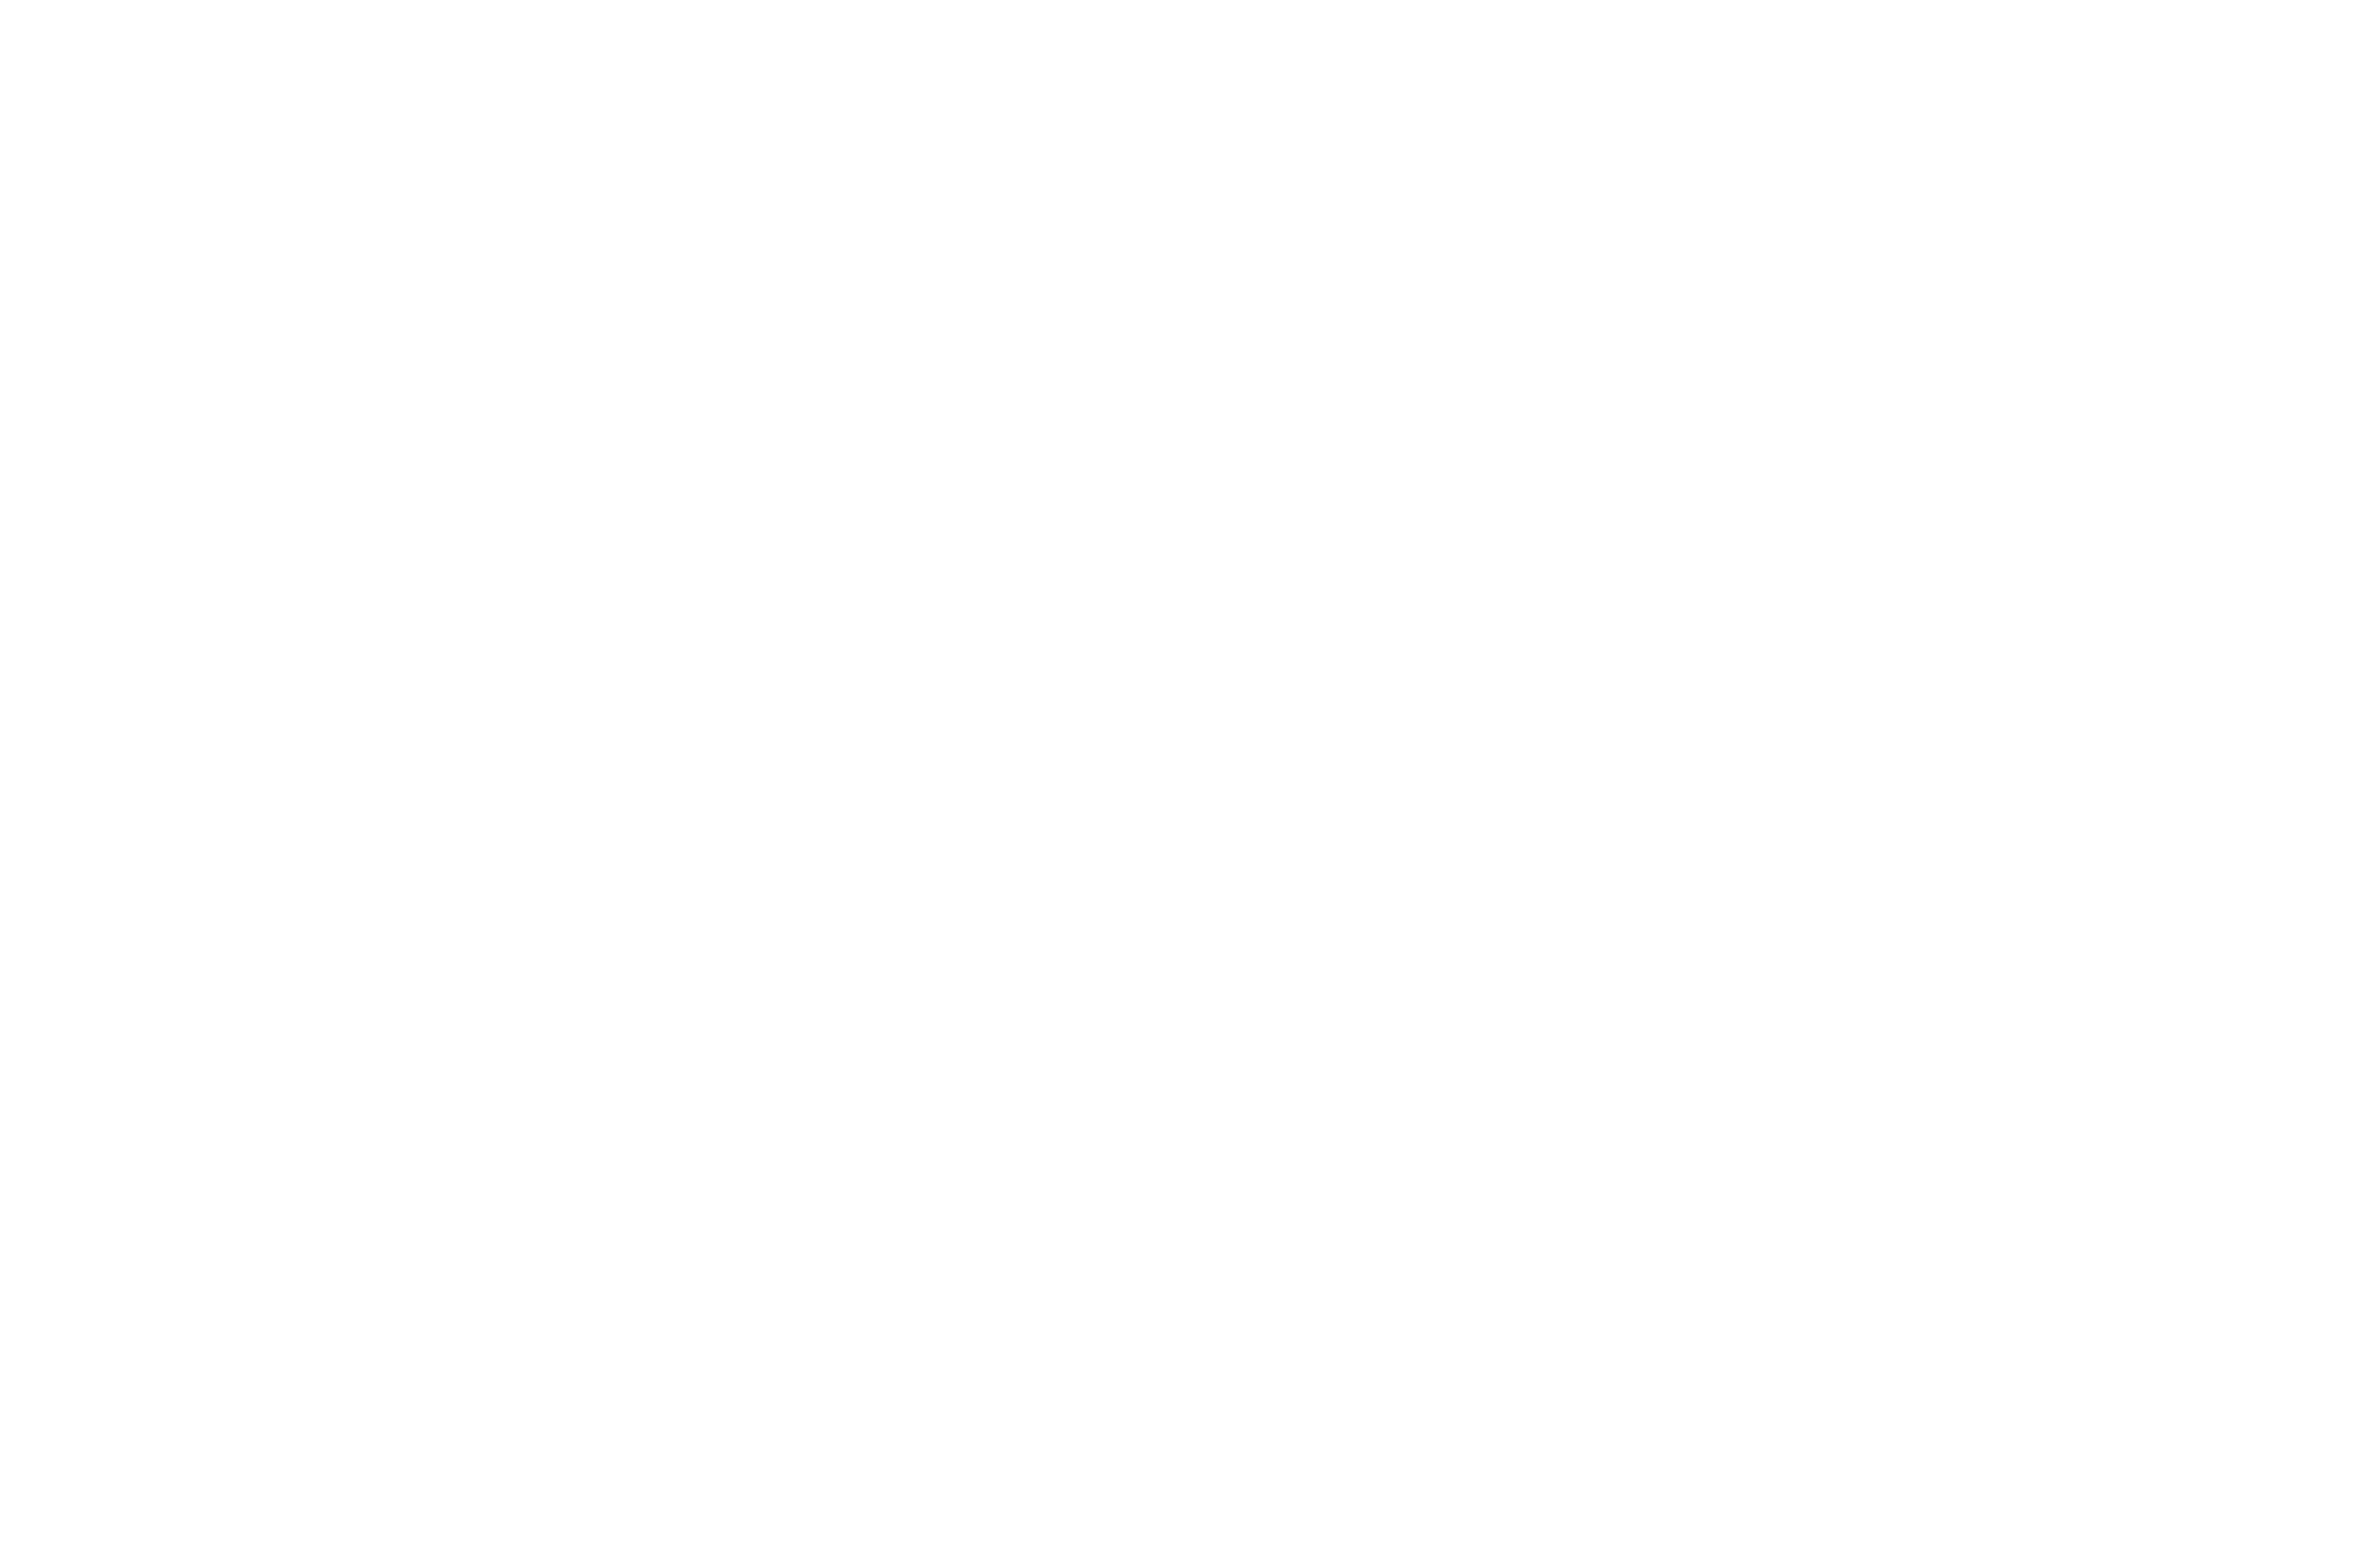

In [6]:
plt.rcParams["figure.dpi"] = 500
plt.axis("off")

# image = images[0]
# plt.imshow(image.rotate(0.5))

for i, image in enumerate(images):
    tmp = image.
    plt.imsave(f"results/original_{i}.png", image, format="png")

## Augmentation

Perform augmentations on images

In [18]:
import albumentations as A

def perform_augmentation(image, augmentation):
    """Perform given augmentation on image and crop to appropriate size for ResNet 50"""

    transform = A.Compose([
        augmentation,
        A.CenterCrop(height=EMBEDDING_IMAGE_SIZE, width=EMBEDDING_IMAGE_SIZE),
    ])

    transformed_image = transform(image=image)['image']
    return transformed_image

def aug_rot(image, angle):
    """Augment image with rotation (int from 0 to 360)"""

    augmentation_rotate = A.Rotate((angle, angle), always_apply=True)
    return perform_augmentation(image, augmentation_rotate)

def aug_colour_jitter(image, hue, sat, val):
    """Colour jitter"""

    augmentation_jitter = A.HueSaturationValue(
        hue_shift_limit=(hue, hue),
        sat_shift_limit=(sat, sat),
        val_shift_limit=(val, val),
        always_apply=True
    )
    return perform_augmentation(image, augmentation_jitter)

def aug_hue(image, hue):
    """Augment image with hue (int from -100 to 100)"""

    return aug_colour_jitter(image, hue, 0, 0)

def aug_sat(image, sat):
    """Augment image with sat (int from -100 to 100)"""

    return aug_colour_jitter(image, 0, sat, 0)

def aug_val(image, val):
    """Augment image with val (int from -100 to 100)"""

    return aug_colour_jitter(image, 0, 0, val)

def aug_zoom(image, zoom):
    """Augment image with zoom (float from 0 to 100)"""

    size = int(ORIGINAL_IMAGE_SIZE * (1 + zoom / 100))
    augmentation_zoom = A.Resize(height=size, width=size, always_apply=True)
    return perform_augmentation(image, augmentation_zoom)

def aug_noise(image, noise):
    """Augment image with noise (float from 0 to 500)"""

    augmentation_noise = A.GaussNoise(var_limit=(noise, noise), always_apply=True)
    return perform_augmentation(image, augmentation_noise)


/home/guillaume/anaconda3/envs/imaad/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Visualise augmented images

In [19]:
# transformed_image = aug_rot(image=image, angle=20)
# transformed_image = aug_hue(image=image, hue=100)

# plt.rcParams["figure.figsize"] = (5,5)
# plt.rcParams["figure.dpi"] = 500

for sat in range(-100, 100 + 1, 5):
    transformed_image = aug_sat(image, sat)
    plt.imsave(f"results/aug_images/sat/img_sat_{sat}.png", transformed_image)
    print("saved sat:", sat)

for hue in range(-100, 100 + 1, 5):
    transformed_image = aug_hue(image, hue)
    plt.imsave(f"results/aug_images/hue/img_hue_{hue}.png", transformed_image)
    print("saved hue:", hue)

for val in range(-100, 100 + 1, 5):
    transformed_image = aug_val(image, val)
    plt.imsave(f"results/aug_images/val/img_val_{val}.png", transformed_image)
    print("saved val:", val)

for zoom in range(0, 60 + 1, 2):
    transformed_image = aug_zoom(image, zoom)
    plt.imsave(f"results/aug_images/zoom/img_zoom_{zoom}.png", transformed_image)
    print("saved zoom:", zoom)

# transformed_image.shape

FileNotFoundError: [Errno 2] No such file or directory: 'results/aug_images/sat/img_sat_-100.png'

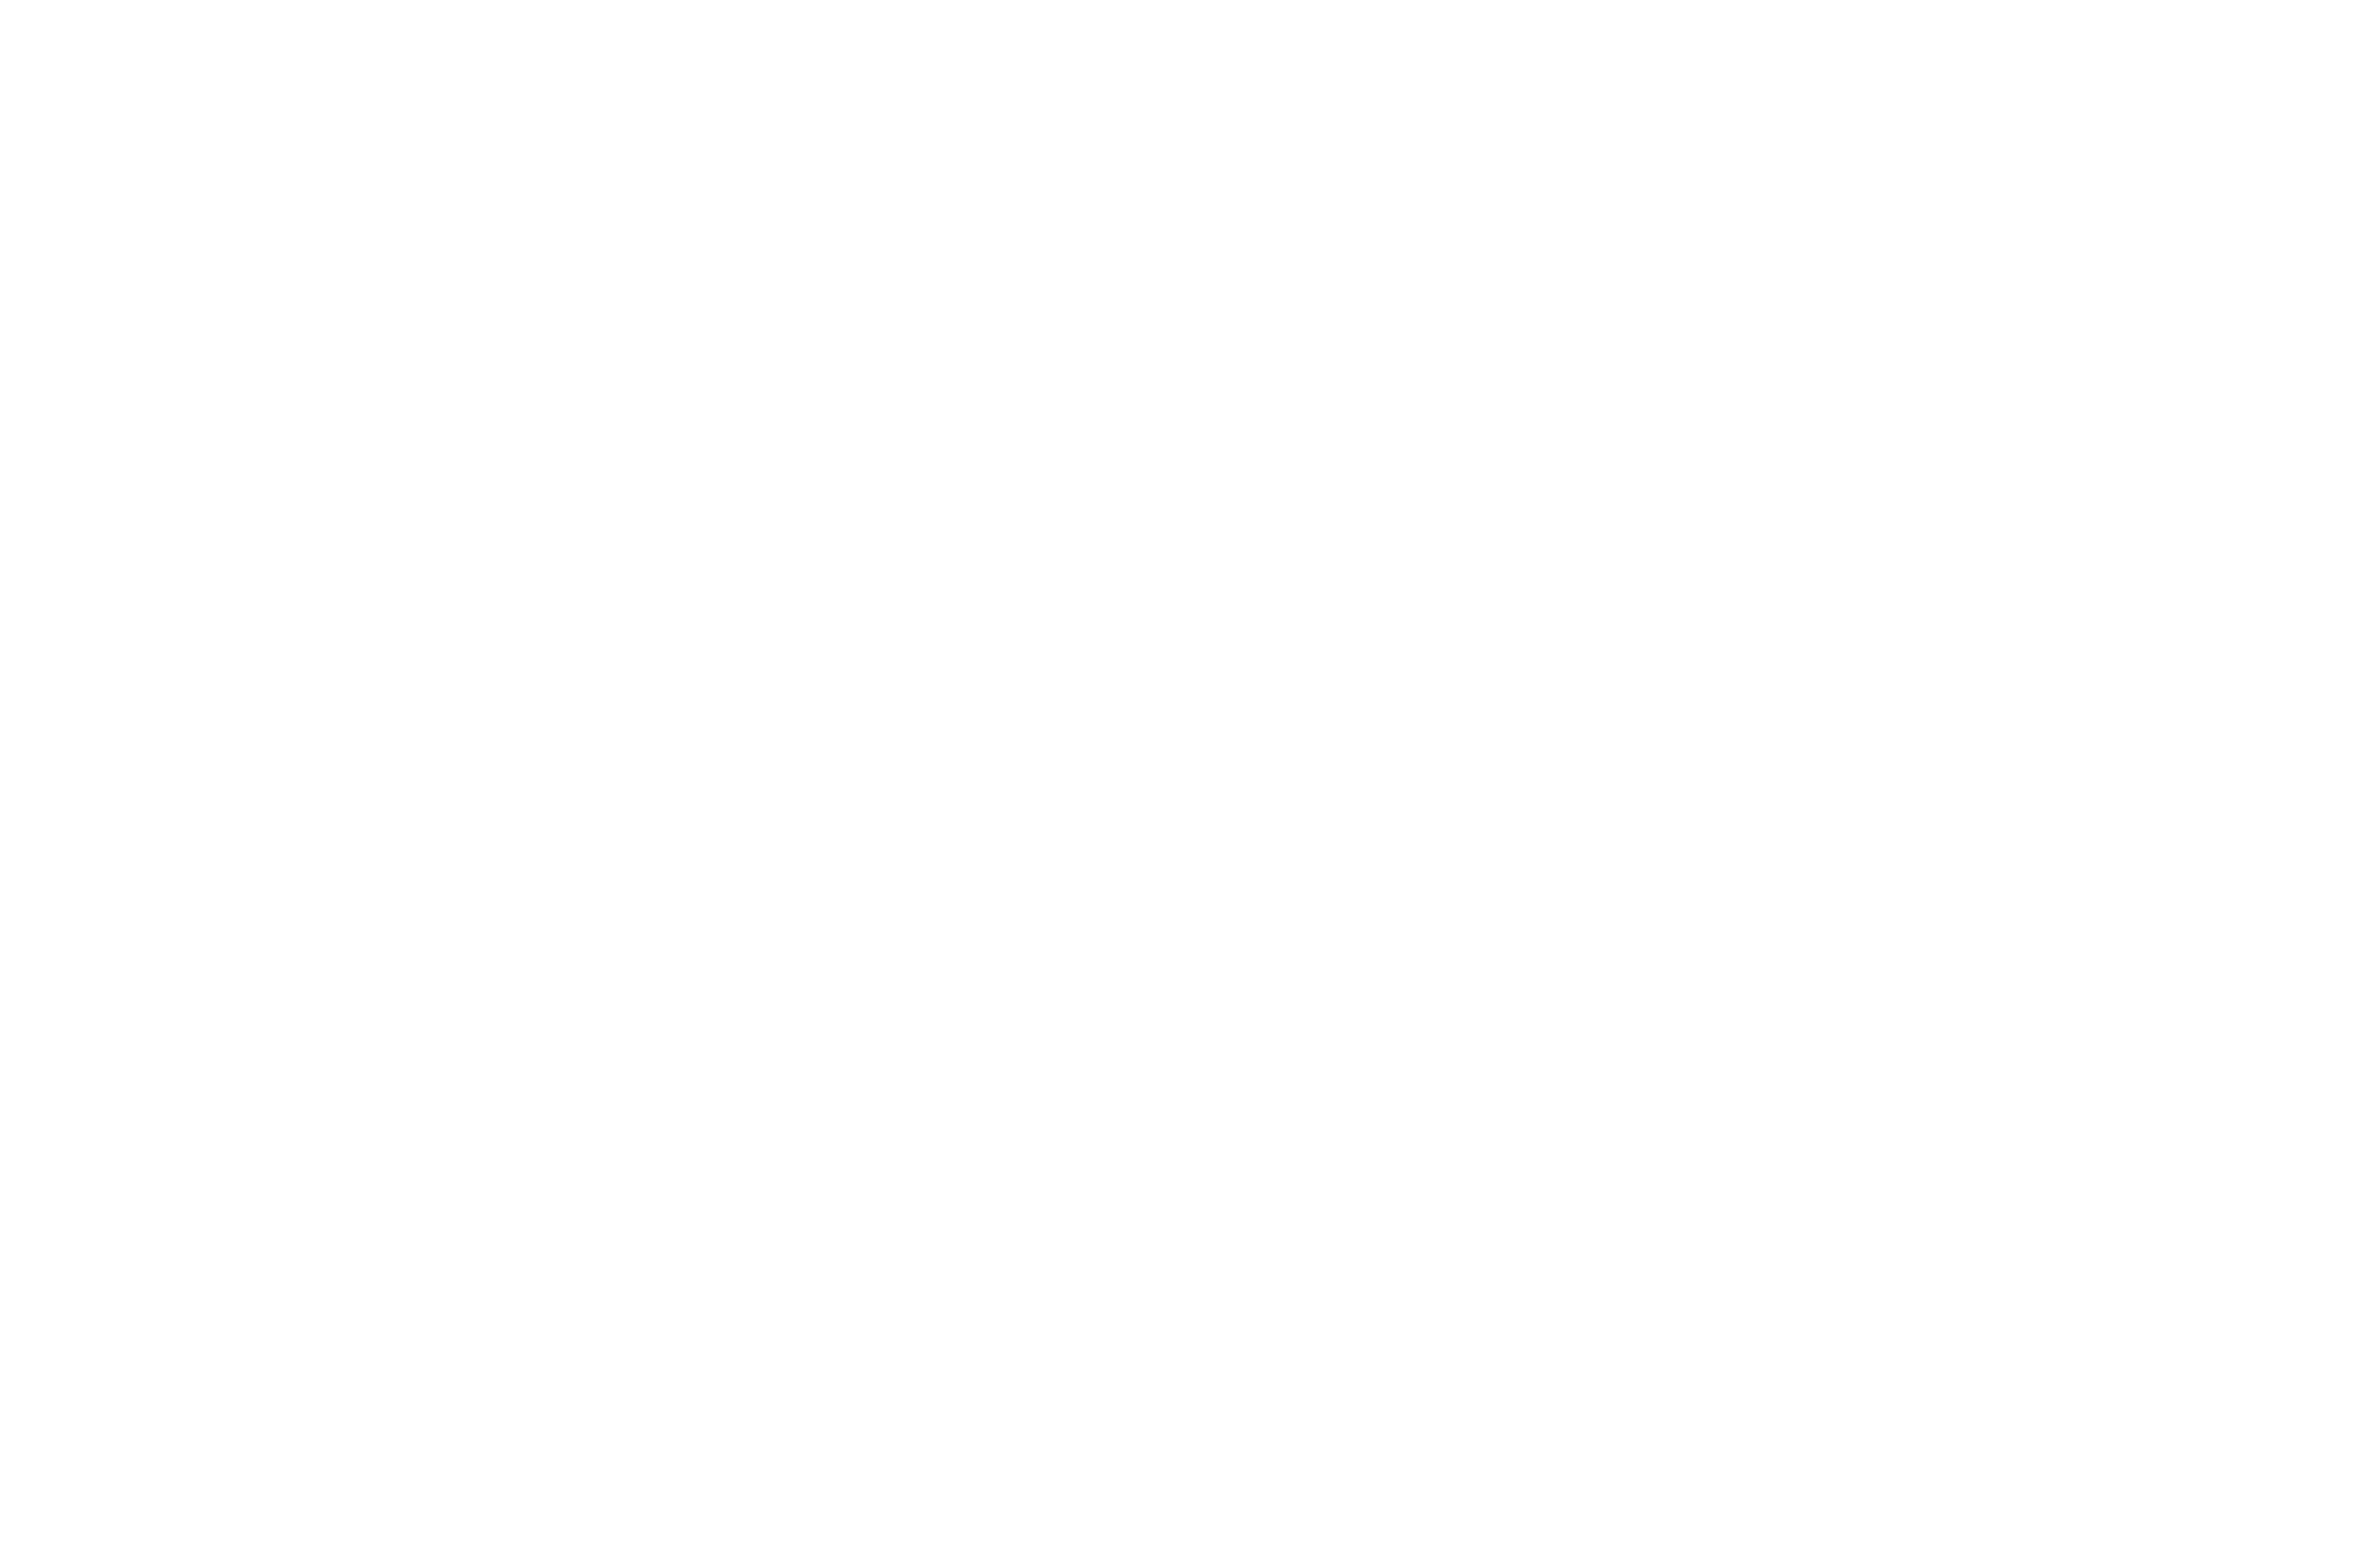

In [20]:
# transformed_image = aug_rot(image=image, angle=20)
# transformed_image = aug_hue(image=image, hue=100)

zoom = 0
# transformed_image = aug_hue(image, hue)
transformed_image = aug_zoom(image=image, zoom=zoom)
plt.axis('off')
# plt.imshow(transformed_image)
plt.savefig(f"img_zoom_{zoom}")

# transformed_image.shape

Convert PIL images into Pytorch tensors

In [21]:
from torchvision import transforms as transform_lib

def convert_to_tensor(image):
    t = transform_lib.Compose([
        transform_lib.ToTensor(),
        transform_lib.CenterCrop(EMBEDDING_IMAGE_SIZE),
        transform_lib.Normalize(
            [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
        )
    ])

    image_tensor =  t(image)
    return image_tensor

/home/guillaume/anaconda3/envs/imaad/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generate augmentation images for specified image and aug type

In [22]:
def generate_aug_images(image, aug, z):
    aug_images = []
    for value in z:
        aug_image = aug(image, value)
        aug_image_tensor = convert_to_tensor(aug_image)
        aug_images.append(aug_image_tensor)
    return aug_images

## Retrieve embeddings

Modified ResNet 50 model

In [23]:
# modified from Pytorch official resnet.py
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch
from torchsummary import summary
import torch.nn.functional as F

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}

class Bottleneck_Baseline(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck_Baseline, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet_Baseline(nn.Module):

    def __init__(self, block, layers):
        self.inplanes = 64
        super(ResNet_Baseline, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1) 

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        return x

def resnet50_baseline(pretrained=False):
    """Constructs a Modified ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet_Baseline(Bottleneck_Baseline, [3, 4, 6, 3])
    if pretrained:
        model = load_pretrained_weights(model, 'resnet50')
    return model

def load_pretrained_weights(model, name):
    pretrained_dict = model_zoo.load_url(model_urls[name])
    model.load_state_dict(pretrained_dict, strict=False)
    return model

Feed augmented images to ResNet 50 and save embeddings

In [24]:
model = resnet50_baseline(pretrained=True)

# only using one image for now
def get_embeddings(aug_images, batch_size=4):
    embeddings = {}
    # print(len(aug_images))
    runs = len(aug_images) // batch_size

    for i in range(runs):
        # print("Running batch {}/{}".format(i + 1, runs))
        batch = aug_images[i * batch_size : (i + 1) * batch_size]
        input = torch.stack(batch, dim=0)
        # print(input.shape)
        # input = input.cuda()

        output = model(input)
        output = output.cpu().detach().numpy()
        # print(output.shape)
        # output_list = output.tolist()
        for j in range(len(output)):
            # print(output[j].shape)
            embeddings[i * batch_size + j] = output[j]
        # print(len(embeddings[i]))
    return embeddings

## Experiment

Augmentation info stored in the `aug_info` dictionary

In [25]:
aug_info = [
    # { "key": "aug_rot", "aug_function": aug_rot, "title": "rotation", "z": np.arange(0, 360, 1) },
    { "key": "aug_hue", "aug_function": aug_hue, "title": "hue", "z": np.arange(-100, 100) },
    { "key": "aug_sat", "aug_function": aug_sat, "title": "saturation", "z": np.arange(-100, 100, 1) },
    { "key": "aug_val", "aug_function": aug_val, "title": "value", "z": np.arange(-100, 100, 1) },
    { "key": "aug_zoom", "aug_function": aug_zoom, "title": "zoom", "z": np.linspace(-15, 15, 100) },
    # {"key": "aug_noise", "aug_function": aug_noise, "title": "gaussian_noise", "z": np.linspace(0, 100, 100) }
]

Data info will be stored in the `data` dictionary

In [26]:
data = {}
for i in range(TOTAL_IMAGES):
    data[i + 1] = {}

Dimensionality reduction using PCA/TSNE

In [27]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def reduce_dims(embeddings, dims=2, method="PCA"):
    embeddings = np.asarray(list(embeddings.values()))

    if method == "PCA":
        dim_reduction = PCA(n_components=dims)
    elif method == "TSNE":
        dim_reduction = TSNE(n_components=dims, learning_rate='auto', init='random')

    embeddings_reduced = dim_reduction.fit_transform(embeddings)

    return embeddings_reduced

In [28]:
embeddings = {"0": [1,2,3], "1": [4,5,6]}
embeddings_pca = reduce_dims(embeddings, dims=2, method="PCA")
embeddings_tsne = reduce_dims(embeddings, dims=2, method="TSNE")
print(embeddings_pca)
print(embeddings_tsne)

[[-2.59807621e+00  3.22548490e-17]
 [ 2.59807621e+00  3.22548490e-17]]
[[ 61.17826     -0.88728815]
 [-61.17826      0.8873072 ]]


Run experiment

In [29]:
DIM_REDUCTION_METHOD = "PCA"

for aug in aug_info:
    for i in range(1, TOTAL_IMAGES + 1):
        print(f"{aug['title']} - {i}/{TOTAL_IMAGES}")

        # augmentation
        aug_images = generate_aug_images(images[i - 1], aug["aug_function"], aug["z"])
        data[i][aug["key"]] = aug_images
        
        # embeddings
        embeddings = get_embeddings(aug_images, batch_size=4)
        data[i]["embeddings_" + aug["key"]] = embeddings

        # reduce dimensions
        data[i]["reduced_" + aug["key"]] = reduce_dims(dims=2, embeddings=embeddings, method=DIM_REDUCTION_METHOD)

hue - 1/4
hue - 2/4
hue - 3/4
hue - 4/4
saturation - 1/4
saturation - 2/4
saturation - 3/4
saturation - 4/4
value - 1/4
value - 2/4
value - 3/4
value - 4/4
zoom - 1/4
zoom - 2/4
zoom - 3/4
zoom - 4/4


Plot images with scatter graphs of their augmented embedding spaces

## Visualise results

Plot images with scatter graphs of their augmented embedding spaces

Plotting embeddings after hue
Plotting embeddings after saturation
Plotting embeddings after value
Plotting embeddings after zoom


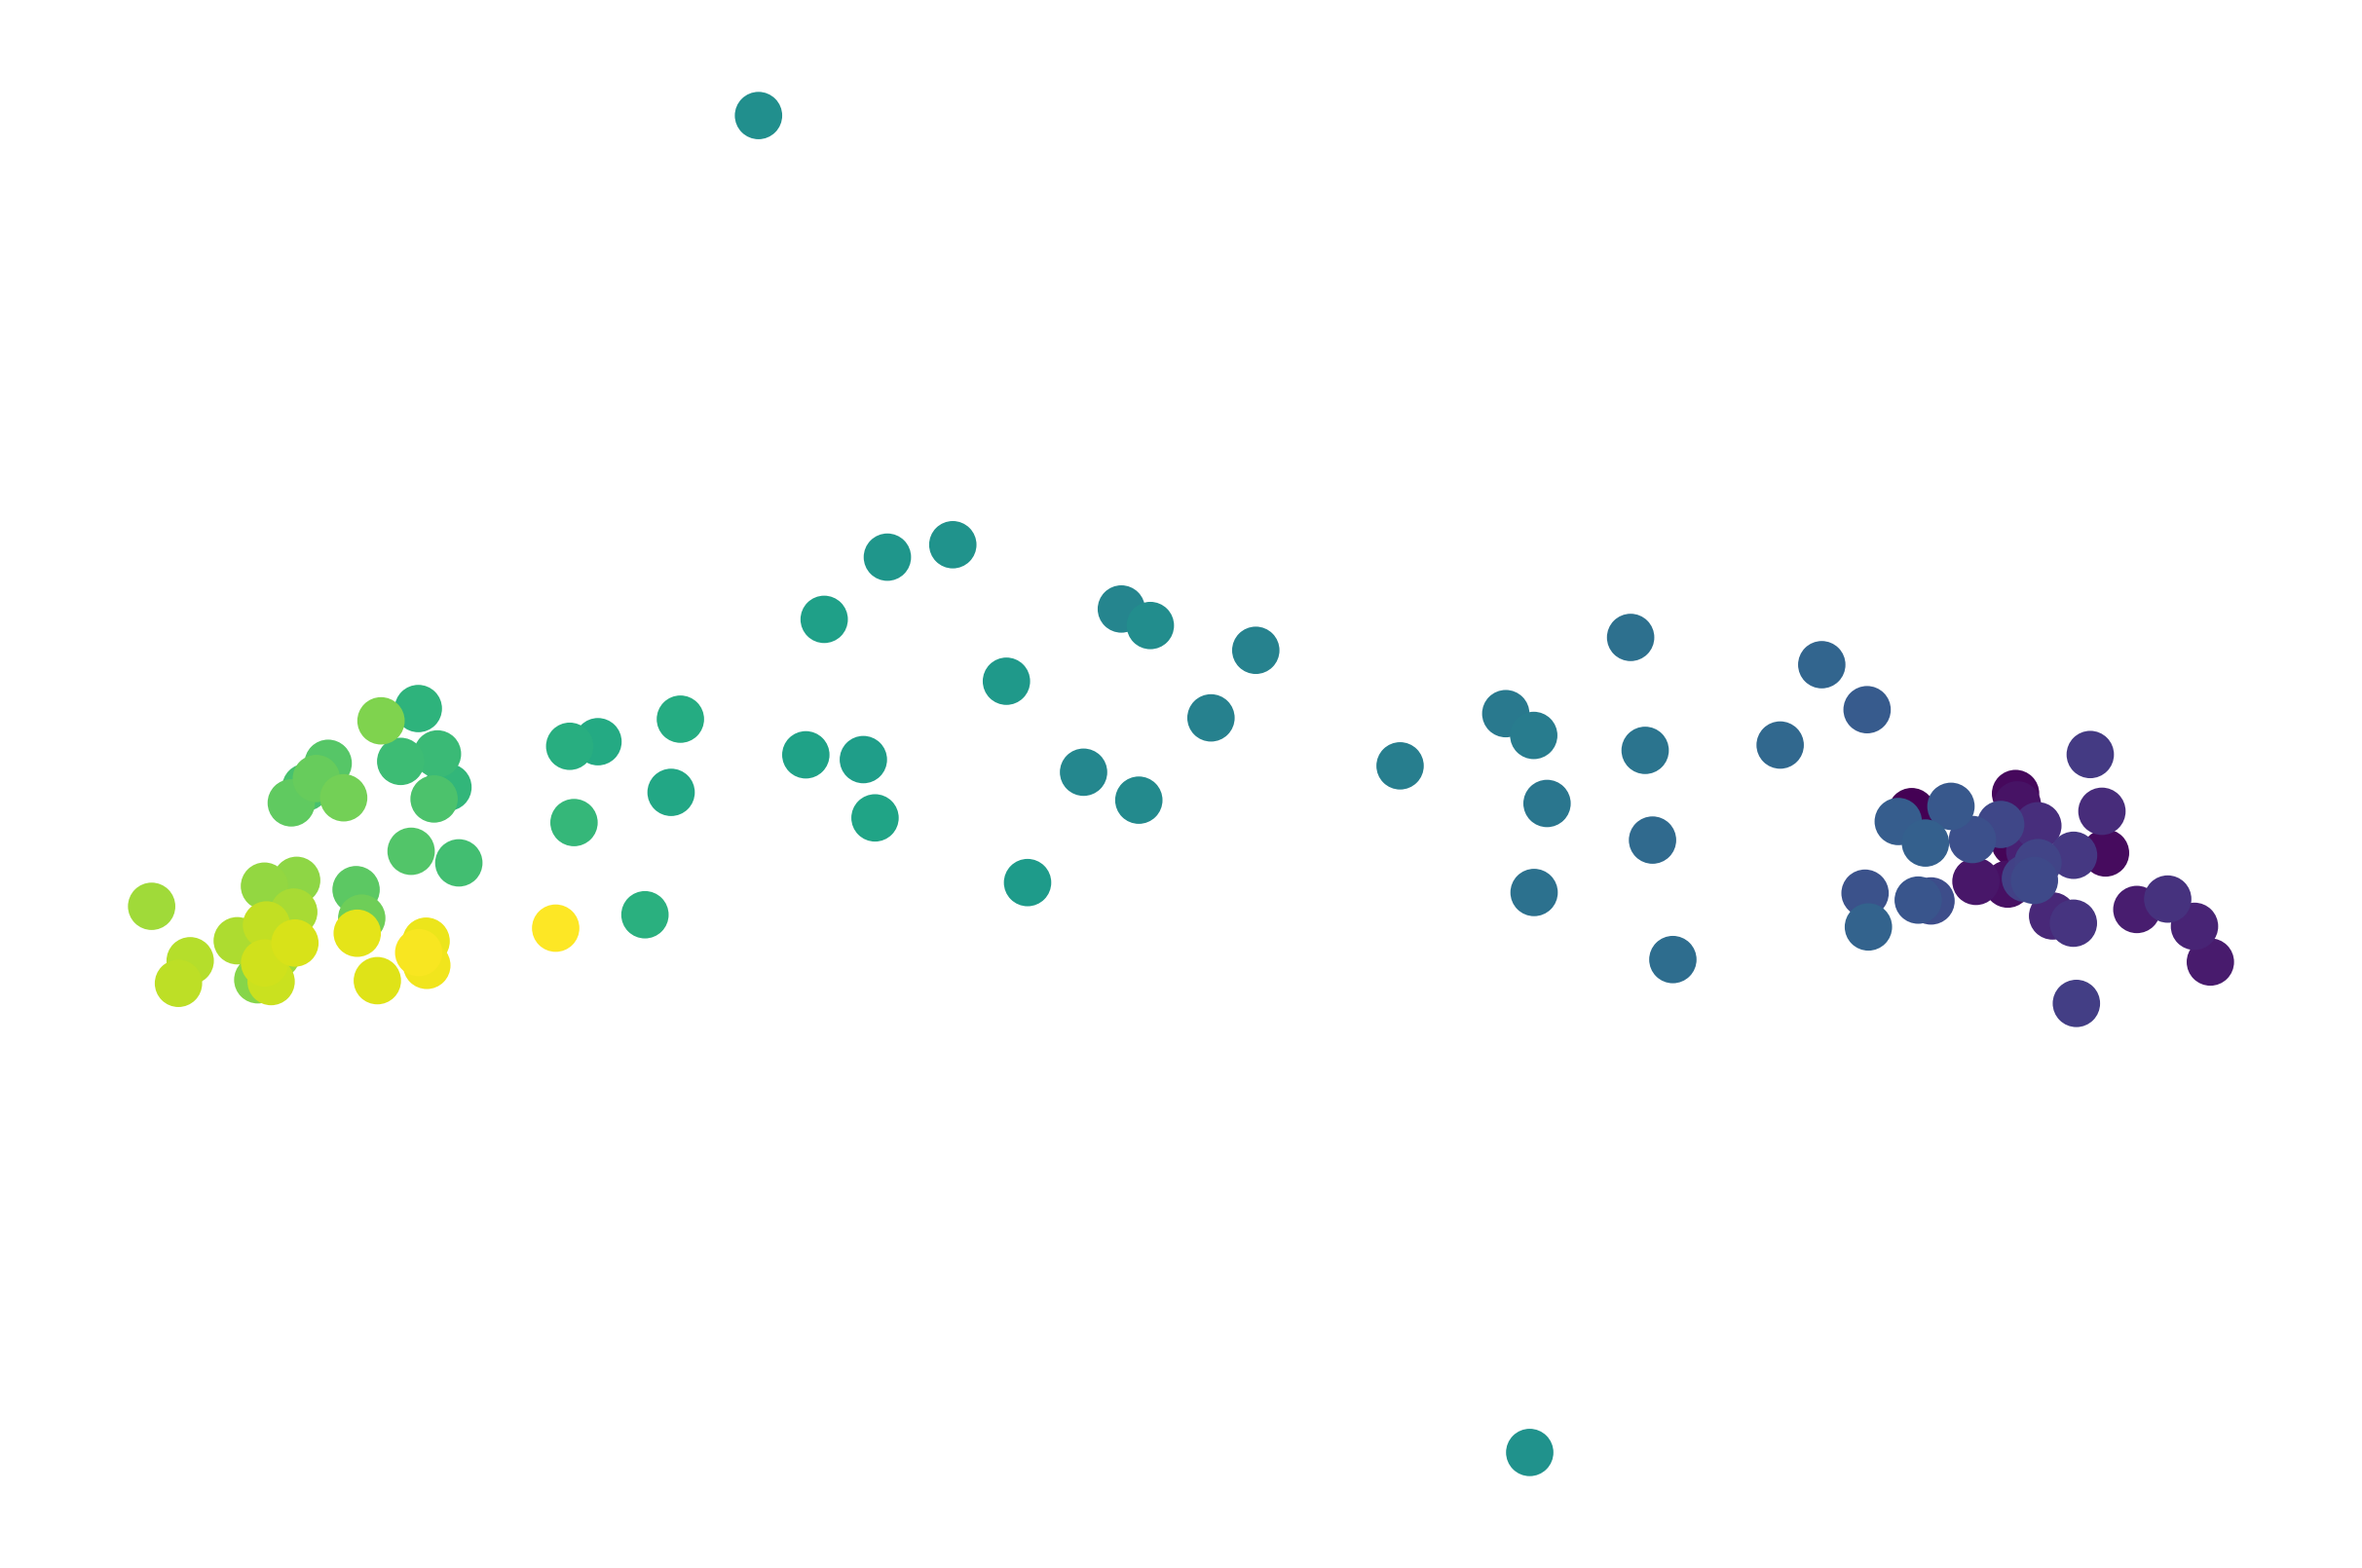

In [36]:
import matplotlib.pyplot as plt


# fig, ax = plt.figure(dpi=500)
# fig = plt.figure(constrained_layout=True, figsize=(4 + 4 * len(aug_info), 10))
# subfigs = fig.subfigures(1, (1 + len(aug_info)), width_ratios=[1] + [2] * len(aug_info))

# plot images
# axs0 = subfigs[0].subplots(TOTAL_IMAGES, 1)
# subfigs[0].suptitle('Images')
# subfigs[0].set_facecolor('0.9')
# for i in range(TOTAL_IMAGES):
    # axs0[i].imshow(images[i])
    # ax.axis('off')
    # axs0[i].set_title('Image {}'.format(i + 1))


def plot_aug_embeddings(col, z, title, key):
    # print("col: {}".format(col))
    # axs = subfigs[col].subplots(TOTAL_IMAGES, 1)
    # subfigs[col].suptitle(f"Embedding space after {title}")

    for i in range(1, TOTAL_IMAGES + 1):
        plt.clf()
        plt.axis("off")

        # print("- row: {}".format(i))
        x = data[i]["reduced_" + key][:, 0]
        y = data[i]["reduced_" + key][:, 1]

        plt.scatter(x, y, c=z, cmap='viridis')
        plt.savefig(f"./results/{title}_{i-1}.png",bbox_inches='tight', pad_inches=0)

    # subfigs[col].colorbar(scatter, ax=axs, shrink=0.6)


for i, aug in enumerate(aug_info):
    print(f"Plotting embeddings after {aug['title']}")
    plot_aug_embeddings(i + 1, aug["z"], aug["title"], aug["key"])


# plt.show()

Experimenting with 3D plots

In [32]:
# What follows is a copy of the 3D plot example code.
# Data is randomly generated so there is no external data import.

for aug in aug_info:
    for i in range(1, TOTAL_IMAGES + 1):
        print(f"{aug['title']} - {i}/{TOTAL_IMAGES}")

        # reduce dimensions
        data[i]["reduced_3d_" + aug["key"]] = reduce_dims(dims = 3, embeddings = data[i]["embeddings_" + aug["key"]], method="PCA")

rotation - 1/4
rotation - 2/4
rotation - 3/4
rotation - 4/4
hue shift - 1/4
hue shift - 2/4
hue shift - 3/4
hue shift - 4/4
saturation shift - 1/4
saturation shift - 2/4
saturation shift - 3/4
saturation shift - 4/4
value shift - 1/4
value shift - 2/4
value shift - 3/4
value shift - 4/4
zoom in - 1/4
zoom in - 2/4
zoom in - 3/4
zoom in - 4/4
gaussian noise - 1/4
gaussian noise - 2/4
gaussian noise - 3/4
gaussian noise - 4/4


In [33]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

i = 4
aug_type = "zoom"
key = "reduced_3d_aug_" + aug_type

ax.scatter(data[i][key][:, 0], data[i][key][:, 1], list(data[i][key][:, 2]))

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.title(f"Embedding space after {aug['title']}")
plt.show()

<IPython.core.display.Javascript object>